Gradient at V_o: 0.09
Gradient at V_o - 5: 0.27
Gradient difference: -0.19


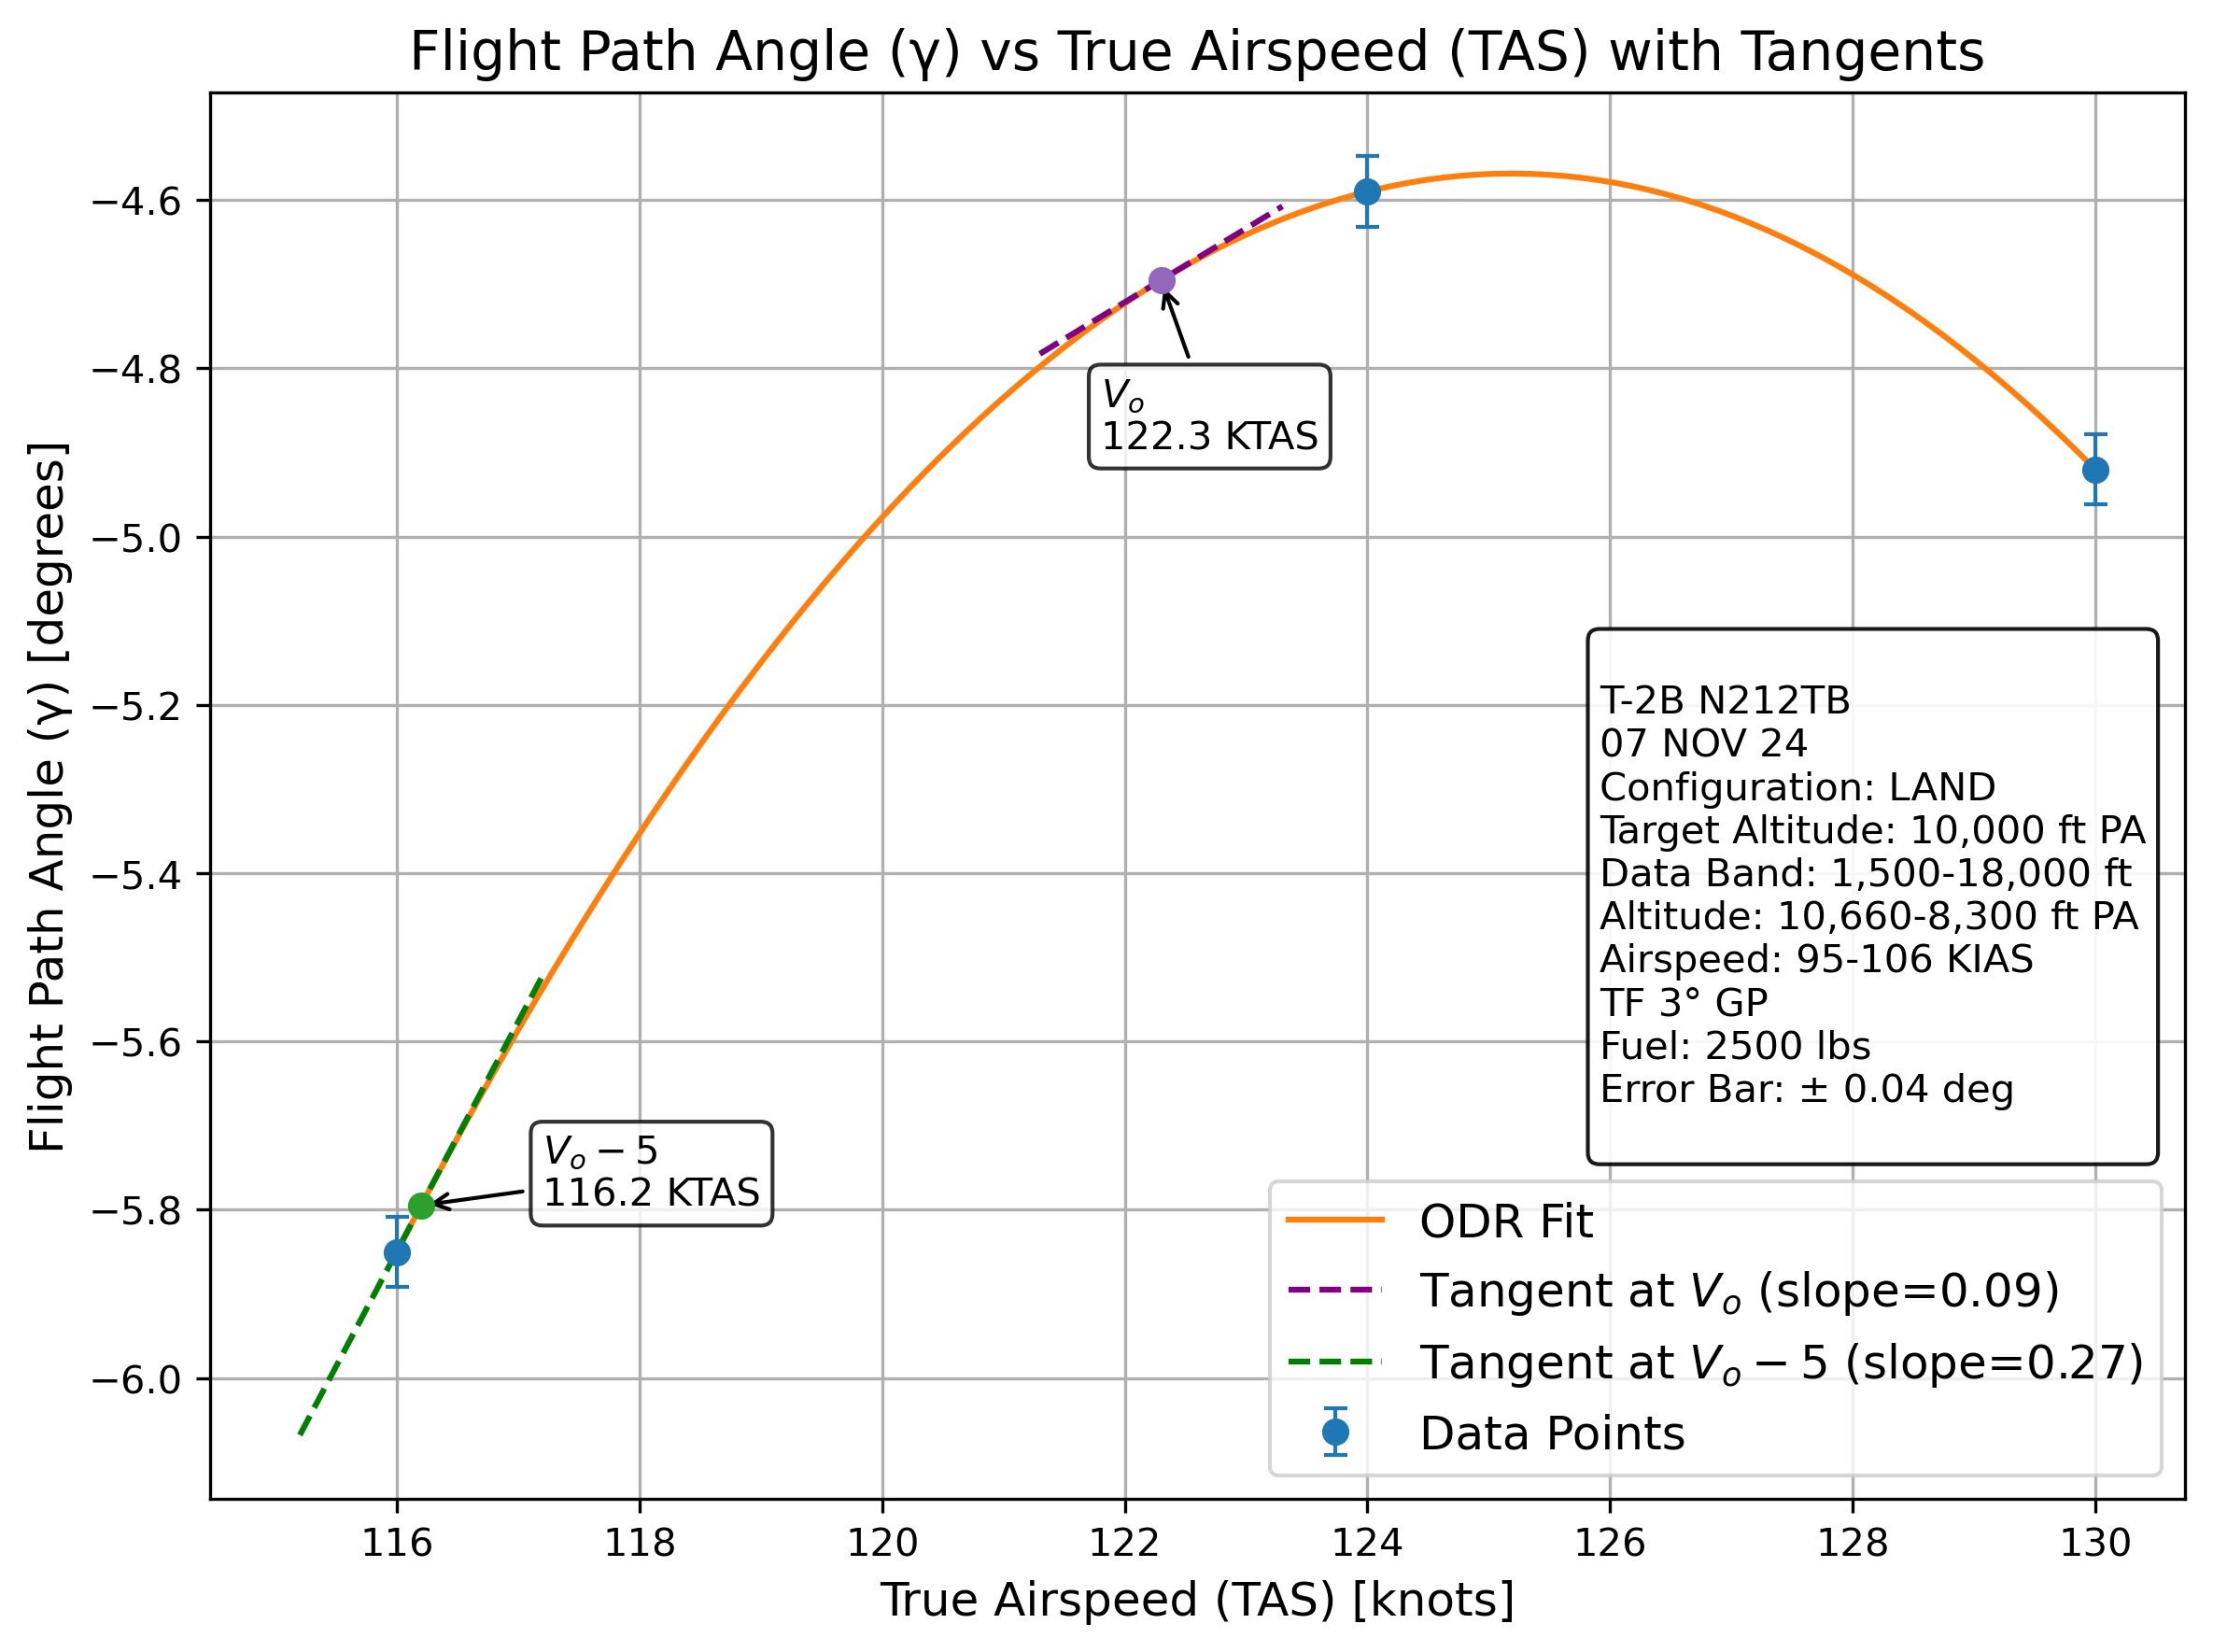

In [123]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import odr

# Data
TAS = [116, 124, 130]  # True Airspeed in knots
gamma = [-5.85, -4.59, -4.92]  # Flight path angle in degrees
# TAS = [116, 121, 124, 130]  # True Airspeed in knots
# gamma = [-5.85, -5.15, -4.59, -4.92]  # Flight path angle in degrees

# Errors in TAS (x) and γ (y)
# TAS_error = [0.5] * len(TAS)
gamma_error = [0.04182] * len(gamma)

# Polynomial Fit using numpy.polyfit
degree = 2  # Degree of the polynomial
coefficients = np.polyfit(TAS, gamma, degree)
poly_fit = np.poly1d(coefficients)

# Generate TAS values for the fit curve
TAS_fit = np.linspace(min(TAS), max(TAS), 100)
gamma_fit = poly_fit(TAS_fit)


# Orthogonal Distance Regression (ODR)
# Define the model function
def poly_func(B, x):
    return B[0] * x**2 + B[1] * x + B[2]


# Initial guess for the parameters (use the coefficients from polyfit)
beta0 = coefficients

# Create a model for ODR
model = odr.Model(poly_func)

# Create data with errors
data = odr.RealData(TAS, gamma, sx=TAS_error, sy=gamma_error)

# Set up ODR with the model and data
odr_obj = odr.ODR(data, model, beta0=beta0)

# Run the regression
output = odr_obj.run()

# Get the fitted parameters
beta_odr = output.beta

# Generate TAS values for the ODR fit curve
gamma_fit_odr = poly_func(beta_odr, TAS_fit)


# Compute the gradient (tangent slope) at V_o and V_o - 5
def compute_gradient_at_x(x):
    return 2 * beta_odr[0] * x + beta_odr[1]


V_o = 122.3  # Example value for V_o
gamma_vo = poly_func(beta_odr, V_o)  # Compute γ at V_o
gradient_vo = compute_gradient_at_x(V_o)  # Gradient at V_o

V_o_minus_5 = V_o - 6.1
gamma_vo_minus_5 = poly_func(beta_odr, V_o_minus_5)  # Compute γ at V_o - 5
gradient_vo_minus_5 = compute_gradient_at_x(V_o_minus_5)  # Gradient at V_o - 5


# Define a function to plot a tangent line
def plot_tangent(x, y, slope, color, label):
    tangent_x = np.linspace(x - 1, x + 1, 100)
    tangent_y = slope * (tangent_x - x) + y
    plt.plot(
        tangent_x,
        tangent_y,
        linestyle="--",
        color=color,
        label=f"{label} (slope={slope:.2f})",
    )


print(f"Gradient at V_o: {gradient_vo:.2f}")
print(f"Gradient at V_o - 5: {gradient_vo_minus_5:.2f}")
print(f"Gradient difference: {gradient_vo - gradient_vo_minus_5:.2f}")

# Plot
plt.figure(figsize=(8, 6), dpi=300)
# Plot data with error bars
plt.errorbar(
    TAS,
    gamma,
    # xerr=TAS_error,
    yerr=gamma_error,
    linewidth=1,
    capsize=3,
    fmt="o",
    label="Data Points",
)
# Plot ODR fit curve
plt.plot(TAS_fit, gamma_fit_odr, linestyle="-", label="ODR Fit")

# Mark Vo and Vo - 5 with markers
plt.scatter(V_o, gamma_vo, color="tab:purple", zorder=5)
plt.annotate(
    "$V_o$\n{:.1f} KTAS".format(V_o),  # Two lines: "$V_o$" and the value of V_o
    xy=(V_o, gamma_vo),
    xytext=(V_o - 0.5, gamma_vo - 0.2),
    arrowprops=dict(facecolor="purple", arrowstyle="->"),
    fontsize=10,
    bbox=dict(
        boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8
    ),
)

plt.scatter(V_o_minus_5, gamma_vo_minus_5, color="tab:green", zorder=5)
plt.annotate(
    "$V_o - 5$\n{:.1f} KTAS".format(V_o_minus_5),
    xy=(V_o_minus_5, gamma_vo_minus_5),
    xytext=(V_o_minus_5 + 1, gamma_vo_minus_5),
    arrowprops=dict(facecolor="orange", arrowstyle="->"),
    fontsize=10,
    bbox=dict(
        boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8
    ),
)

# Plot the tangent lines
plot_tangent(V_o, gamma_vo, gradient_vo, "purple", "Tangent at $V_o$")
plot_tangent(
    V_o_minus_5, gamma_vo_minus_5, gradient_vo_minus_5, "green", "Tangent at $V_o - 5$"
)

# Add a data block to the plot
data_block = """
T-2B N212TB
07 NOV 24
Configuration: LAND
Target Altitude: 10,000 ft PA
Data Band: 1,500-18,000 ft
Altitude: 10,660-8,300 ft PA
Airspeed: 95-106 KIAS
TF 3° GP
Fuel: 2500 lbs
Error Bar: ± 0.04 deg
"""

plt.gcf().text(
    0.72, 0.61,  # Position: X, Y in figure coordinates
    data_block,
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.9),
    verticalalignment="top",
)


# Plot details
plt.title("Flight Path Angle (γ) vs True Airspeed (TAS) with Tangents", fontsize=14)
plt.xlabel("True Airspeed (TAS) [knots]", fontsize=12)
plt.ylabel("Flight Path Angle (γ) [degrees]", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("./output/plots/fps_3pts_tangents.png")
plt.show()